## Loading in and checking the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Using plaidml.keras.backend backend.


In [2]:
train_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")

## Splitting the data and its label

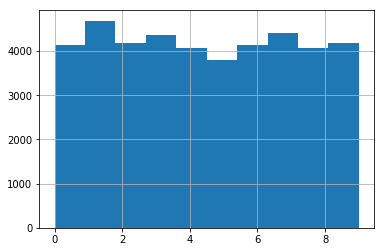

In [3]:
train_label = train_data['label']
train_data = train_data.drop('label', axis=1)
train_label.hist()

In [4]:
train_data = train_data / 255.0
test_data = test_data / 255.0

In [5]:
train_data = train_data.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)

In [6]:
train_label = to_categorical(train_label, num_classes=10)

In [7]:
s_train_data, s_val_data, s_train_label, s_val_label = train_test_split(train_data, train_label, test_size=0.1, stratify=train_label)

## Checking the image quality of a random value

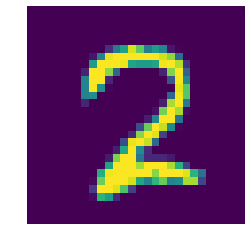

In [10]:
some_digit = s_train_data[2000]
some_digit_image = some_digit[:,:,0]

plt.imshow(some_digit_image, interpolation='nearest')

plt.axis('off')
plt.show()


# Attempting to solve using a CNN

In [11]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

INFO:plaidml:Opening device "metal_amd_radeon_vega_frontier_edition.0"


In [12]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 30
batch_size = 7680 # Warning size choosen based on a GPU with 16GB of memory and utalizes ~95%.

## Testing results with given data

In [ ]:
history = model.fit(s_train_data, s_train_label, batch_size = batch_size, epochs = epochs, 
validation_data = (s_val_data, s_val_label), verbose = 2)


Train on 37800 samples, validate on 4200 samples
Epoch 1/60


INFO:plaidml:Analyzing Ops: 121 of 303 operations complete
INFO:plaidml:Analyzing Ops: 121 of 303 operations complete


 - 31s - loss: 2.1989 - acc: 0.2832 - val_loss: 1.9564 - val_acc: 0.5255
Epoch 2/60
 - 71s - loss: 1.7312 - acc: 0.5188 - val_loss: 1.0468 - val_acc: 0.7514
Epoch 3/60
 - 89s - loss: 0.9358 - acc: 0.7110 - val_loss: 0.5692 - val_acc: 0.8443
Epoch 4/60
 - 92s - loss: 0.6322 - acc: 0.7983 - val_loss: 0.5145 - val_acc: 0.8236
Epoch 5/60
 - 85s - loss: 0.5040 - acc: 0.8309 - val_loss: 0.2531 - val_acc: 0.9255
Epoch 6/60
 - 83s - loss: 0.3279 - acc: 0.8965 - val_loss: 0.2487 - val_acc: 0.9160
Epoch 7/60
 - 87s - loss: 0.3241 - acc: 0.8972 - val_loss: 0.4088 - val_acc: 0.8714
Epoch 8/60
 - 87s - loss: 0.4067 - acc: 0.8712 - val_loss: 0.1621 - val_acc: 0.9436
Epoch 9/60
 - 87s - loss: 0.2116 - acc: 0.9347 - val_loss: 0.1343 - val_acc: 0.9571
Epoch 10/60


## Generating more data!

In [24]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [25]:
datagen.fit(s_train_data)

In [34]:
import scipy.ndimage
history = model.fit_generator(datagen.flow(s_train_data,s_train_label, batch_size=batch_size),
                              epochs = epochs, validation_data = (s_val_data,s_val_label),
                              verbose = 2, steps_per_epoch=s_train_data.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/60
 - 21s - loss: 0.0468 - acc: 0.9874 - val_loss: 0.0290 - val_acc: 0.9931
Epoch 2/60
 - 22s - loss: 0.0469 - acc: 0.9860 - val_loss: 0.0293 - val_acc: 0.9926
Epoch 3/60
 - 21s - loss: 0.0470 - acc: 0.9869 - val_loss: 0.0286 - val_acc: 0.9926
Epoch 4/60
 - 21s - loss: 0.0443 - acc: 0.9885 - val_loss: 0.0288 - val_acc: 0.9921
Epoch 5/60
 - 22s - loss: 0.0453 - acc: 0.9876 - val_loss: 0.0283 - val_acc: 0.9926
Epoch 6/60
 - 22s - loss: 0.0465 - acc: 0.9870 - val_loss: 0.0279 - val_acc: 0.9926
Epoch 7/60
 - 22s - loss: 0.0445 - acc: 0.9874 - val_loss: 0.0282 - val_acc: 0.9926
Epoch 8/60
 - 22s - loss: 0.0444 - acc: 0.9871 - val_loss: 0.0299 - val_acc: 0.9926
Epoch 9/60
 - 22s - loss: 0.0449 - acc: 0.9879 - val_loss: 0.0313 - val_acc: 0.9924
Epoch 10/60
 - 22s - loss: 0.0417 - acc: 0.9874 - val_loss: 0.0303 - val_acc: 0.9921
Epoch 11/60
 - 21s - loss: 0.0467 - acc: 0.9867 - val_loss: 0.0305 - val_acc: 0.9924
Epoch 12/60
 - 21s - loss: 0.0485 - acc: 0.9867 - val_loss: 0.0303 - val_a

## Building our results

In [35]:
results = model.predict(test_data)

In [36]:
results = np.argmax(results,axis = 1)

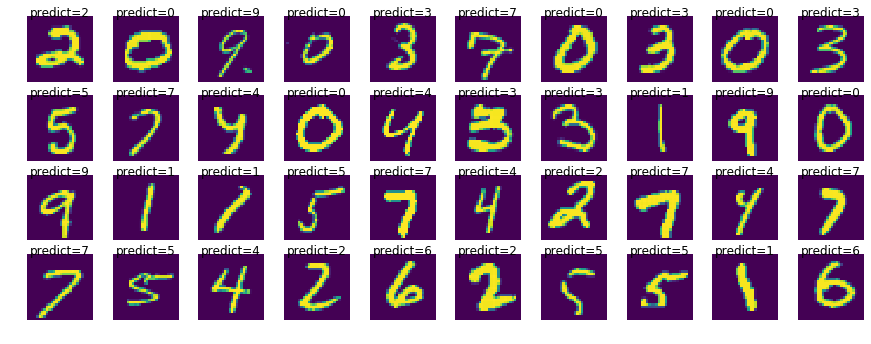

In [21]:
# Preview predictions
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(test_data[i][:,:,0])
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [37]:
# Exporting our results for Kaggle
df = pd.DataFrame(results)
df.index.name='ImageId'
df.index+=1
df.columns=['Label']
df.to_csv('./datasets/results.csv', header=True)